In [776]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.preprocessing import StandardScaler

import warnings
import itertools
import time
from joblib import load, dump

In [777]:
warnings.filterwarnings("ignore")

In [778]:
data_df = pd.read_csv("../data/data.csv")
billboard_df = pd.read_csv("../data/billboard/hot-100_all.csv")
pop_metrics = pd.read_csv("../data/popularity_metrics.csv")

data_df.drop(labels='Unnamed: 0', axis=1, inplace=True)
mfccs = data_df.filter(regex='mfcc*')
data_df = data_df.filter(regex='^((?!mfcc).)*$')
pop_metrics.drop(labels='Unnamed: 0', axis=1, inplace=True)
# pop_metrics['avg_rank_score'] = pop_metrics['avg_rank_score'].apply(lambda x: x*100)

In [779]:
data_df

,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,var_segment_loudness_max_end_diff,mean_segment_num_pitches,var_segment_num_pitches,mean_segment_num_pure_pitches,var_segment_num_pure_pitches,mean_segment_timbre,var_segment_timbre,num_tatums,mean_tatum_duration,var_tatum_duration
0,0.796196,-2.178146,0.030618,0.513133,-0.277509,0.778521,-0.806495,-0.236372,-0.153169,-0.839151,...,1.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,-1.0,1.0
1,-1.466521,-0.508462,-0.921567,0.790982,-0.776142,0.778521,-0.712676,1.541868,-0.153169,2.511305,...,1.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,-1.0,1.0
2,-1.373778,0.580463,-1.216437,-0.876113,-0.665248,0.778521,-0.823191,1.656466,-0.153169,-0.882363,...,1.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,-1.0,1.0
3,-1.283932,0.111895,-1.517450,-1.431812,-2.446135,0.778521,-0.870895,1.403561,-0.153169,-0.799026,...,1.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,-1.0,1.0
4,0.287341,0.191090,0.859939,-1.431812,1.260264,0.778521,-0.797749,-0.125726,-0.126556,-0.719547,...,1.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,-1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1418,0.607892,-0.567858,1.025804,-1.153963,0.709287,-1.284487,-0.748454,-0.714917,-0.153169,-0.258879,...,1.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,-1.0,1.0
1419,0.424180,0.336280,-1.093574,-1.153963,-1.697798,0.778521,0.319326,-0.806990,-0.149733,-0.505803,...,1.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,-1.0,1.0
1420,-0.596684,0.098696,-0.614410,-0.042566,-0.772652,-1.284487,1.297263,-0.808966,-0.153169,1.816830,...,1.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,-1.0,1.0
1421,0.005151,1.379008,-0.884708,0.513133,-1.479113,0.778521,0.621453,-0.856109,-0.153169,-0.251162,...,1.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,-1.0,1.0


In [780]:
billboard_df

,title,artist,image,peakPos,lastPos,weeks,rank,isNew,date
0,All I Want For Christmas Is You,Mariah Carey,NaN,1,1,37,1,False,2020-01-04
1,Rockin' Around The Christmas Tree,Brenda Lee,NaN,2,2,32,2,False,2020-01-04
2,Jingle Bell Rock,Bobby Helms,NaN,3,9,30,3,False,2020-01-04
3,A Holly Jolly Christmas,Burl Ives,NaN,4,6,15,4,False,2020-01-04
4,Circles,Post Malone,NaN,1,3,17,5,False,2020-01-04
...,...,...,...,...,...,...,...,...,...
10495,Bubbly,Young Thug With Drake & Travis Scott,NaN,20,100,10,96,False,2022-01-01
10496,Do It To It,Acraze Featuring Cherish,NaN,97,0,1,97,True,2022-01-01
10497,No Love,Summer Walker & SZA,NaN,13,96,7,98,False,2022-01-01
10498,Knowing You,Kenny Chesney,NaN,57,84,19,99,False,2022-01-01


In [781]:
pop_metrics

,peak_rank,debut_rank,lifetime_peak_rank,sensationality,avg_rank_score,std_rank_score,time_on_chart,num_occurrences,rank_sum,skewness,kurtosis,spotify_popularity
0,1,1,1,0.999999,0.270183,0.316913,50,14,2.161467,1.395650,0.673814,69.0
1,2,2,2,0.998958,0.123908,0.156764,44,17,1.362990,1.352697,0.450922,62.0
2,3,3,3,0.981122,0.151254,0.099182,41,12,1.210036,0.477332,-0.985764,62.0
3,4,4,4,0.931350,0.121060,0.075093,25,11,0.968480,0.378995,-1.307941,54.0
4,1,5,1,0.999999,0.153094,0.215097,61,47,2.908793,3.182407,9.711951,86.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1418,79,79,79,0.012658,0.012658,0.000000,1,1,0.012658,0.000000,-3.000000,41.0
1419,85,85,85,0.011764,0.011765,0.000000,1,1,0.011765,0.000000,-3.000000,66.0
1420,91,91,91,0.010989,0.010989,0.000000,1,1,0.010989,0.000000,-3.000000,69.0
1421,95,95,95,0.010526,0.010526,0.000000,1,1,0.010526,0.000000,-3.000000,70.0


In [782]:
pop_metrics.describe()

,peak_rank,debut_rank,lifetime_peak_rank,sensationality,avg_rank_score,std_rank_score,time_on_chart,num_occurrences,rank_sum,skewness,kurtosis,spotify_popularity
count,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.00000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000
mean,50.872804,60.858749,49.780745,0.173917,0.025285,0.015060,8.41532,7.326072,0.221581,0.450854,-1.188760,67.404076
std,28.872677,28.879139,29.203101,0.264423,0.031150,0.045298,10.98796,9.710895,0.485595,0.822457,2.763996,17.661345
min,1.000000,1.000000,1.000000,0.010000,0.010000,0.000000,1.00000,1.000000,0.010000,-1.361391,-3.000000,0.000000
25%,26.000000,39.000000,25.000000,0.014492,0.012616,0.000000,1.00000,1.000000,0.014493,0.000000,-3.000000,64.000000
50%,53.000000,66.000000,52.000000,0.040918,0.015764,0.001422,2.00000,2.000000,0.040831,0.000000,-2.000000,70.000000
75%,76.000000,86.000000,75.000000,0.221774,0.023810,0.008715,14.00000,11.000000,0.196657,0.701393,-0.694673,77.000000
max,100.000000,100.000000,100.000000,1.000000,0.409608,0.424401,90.00000,87.000000,3.697960,4.800006,22.324941,95.000000


In [783]:
MIN_PREDICTORS = 40
MAX_PREDICTORS = 40
assert MIN_PREDICTORS <= MAX_PREDICTORS, "MIN_PREDICTORS must be <= MAX_PREDICTORS"

In [784]:
def gscv(mdl, param_grid, x_, y_, score_method, verbose=0):
    grid_search = GridSearchCV(mdl, param_grid=param_grid, n_jobs=-1, verbose=verbose, scoring=score_method)
    grid_search.fit(x_, y_)
    if verbose == 1:
        print(f"best params = {grid_search.best_params_}")
        print(f"best score = {grid_search.best_score_}")
    return grid_search.best_params_, grid_search.best_score_

In [785]:
def process_subset(model, X, y, features):
    kf = KFold()
    mse = []
    X = X[list(features)]
    for train_idx, test_idx in kf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        regr = model.fit(X_train, y=y_train)
        y_predict = regr.predict(X_test)
        mse.append(mean_squared_error(y_test, y_predict))
    return {"model": model, "features": features, "MSE":np.mean(mse)}

In [786]:
def best_subset(model, X, y, subset_size=-1, force=False):
    limit = 100000
    if subset_size == -1:
        subset_size = len(X.columns)
    assert len(X.columns) >= subset_size, f"X.columns must be >= subset_size. Given len(X.columns)={len(X.columns)}, subset_size={subset_size}"

    num_combinations = np.math.factorial(len(X.columns))/(np.math.factorial(len(X.columns)-subset_size) * np.math.factorial(subset_size))
    if num_combinations > limit and not force:
        print(f"Please be aware that this action will run {int(num_combinations)} models and there is a real possibility it will crash your system.\nIf you're ABSOLUTELY SURE you want to do this please include the parameter 'force=True' when calling this function")
        return {"model": model, "features": X.columns, "MSE": -1}
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, subset_size):
        results.append(process_subset(model, X, y, combo))
    models = pd.DataFrame(results)
    best_model = models.loc[models['MSE'].argmin()]
    toc = time.time()
    print("Processed", models.shape[0], "models on", subset_size, "predictors in", (toc-tic), "seconds.")
    return best_model

In [787]:
def stepwise_selection(model, X, y, direction='forward', num_features=None, scoring='neg_root_mean_squared_error'):
    sfs = SequentialFeatureSelector(model, direction=direction, n_features_to_select=num_features, scoring=scoring)
    sfs.fit(X, y)
    return sfs.transform(X), sfs.get_support()

In [788]:
# get n samples from 1-dimensional df following a gaussian distribution
def sample(df: pd.DataFrame, n=400, plot=False):
    x = np.sort(df)
    f_x = np.gradient(x)*np.exp(-x**2/2)
    sample_probs = f_x/np.sum(f_x)
    df_samples = df.sort_values().sample(n=n, weights=sample_probs, replace=False)
    if plot:
        sns.distplot(df_samples)
    return df_samples

In [789]:
# tic = time.time()
# features, idx_mask = stepwise_selection(Ridge(), data_df, pop_metrics['avg_rank_score'], num_features=70)
# toc = time.time()
# print(toc-tic)
# fs = data_df.loc[:, idx_mask==True]

In [790]:
# features, idx_mask = stepwise_selection(LinearRegression(), data_df, pop_metrics['avg_rank_score'], direction='backward')
# bs = data_df.loc[:, idx_mask==True]

In [791]:
def run_regression(model, X, y):
    mse = []
    for train_idx, test_idx in KFold().split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        regr = model.fit(X_train, y=y_train)
        y_predict = regr.predict(X_test)
        mse.append(mean_squared_error(y_test, y_predict))
    return np.mean(mse)

# Balancing Data And Extracting Training and Testing Samples

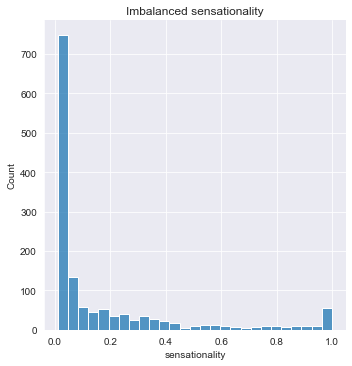

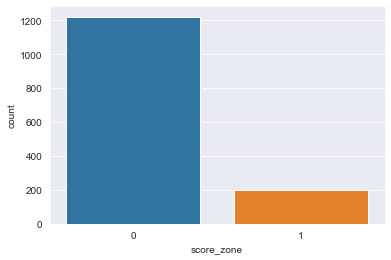

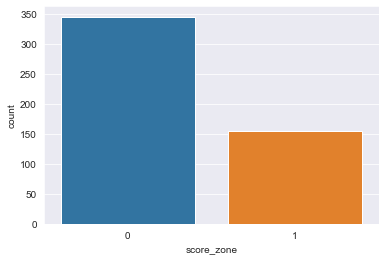

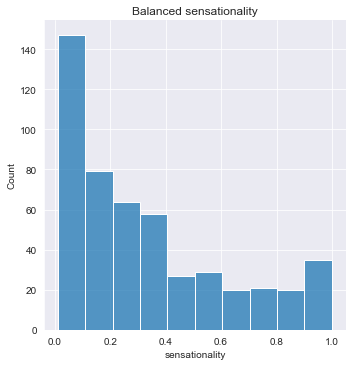

,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,var_segment_loudness_max_end_diff,mean_segment_num_pitches,var_segment_num_pitches,mean_segment_num_pure_pitches,var_segment_num_pure_pitches,mean_segment_timbre,var_segment_timbre,num_tatums,mean_tatum_duration,var_tatum_duration
514,-0.375062,0.534266,-0.000098,1.624529,0.357608,0.778521,-0.445532,-0.188953,-0.153169,-0.220297,...,1.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,-1.0,1.0
556,-0.568843,0.362678,-2.119476,-1.153963,-0.147617,0.778521,-0.821601,1.620901,-0.153169,-0.521236,...,1.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,-1.0,1.0
16,-0.650276,-0.079491,0.049047,1.346680,0.815528,0.778521,-0.905879,-0.279840,-0.153169,-0.528952,...,1.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,-1.0,1.0
516,-0.904960,1.332811,-0.442403,0.235283,0.128066,0.778521,0.685058,-0.161291,-0.153169,-0.544385,...,1.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,-1.0,1.0
652,0.371927,-0.752645,-2.438918,-1.431812,-1.843200,0.778521,-0.732553,2.383569,-0.153169,-0.528952,...,1.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,-1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,-0.168198,-2.290339,-2.531065,-1.153963,-3.289467,0.778521,-0.840683,2.751072,-0.152290,-0.320610,...,1.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,-1.0,1.0
1039,-0.665684,0.804848,0.036761,1.624529,0.388239,-1.284487,-0.157717,-0.856188,-0.153169,-0.366908,...,1.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,-1.0,1.0
1240,0.388871,-0.548059,0.294772,0.790982,-0.210043,0.778521,-0.598186,-0.736651,-0.152078,-0.413206,...,1.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,-1.0,1.0
239,-0.741088,0.125095,1.388248,0.790982,0.847710,-1.284487,-0.429631,-0.544205,-0.153091,-0.781278,...,1.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,-1.0,1.0


In [814]:
balance_metric = 'sensationality'

sns.displot(pop_metrics[balance_metric])
plt.title('Imbalanced ' + balance_metric)
plt.show()

pop_metrics['score_zone'] = pop_metrics[balance_metric].apply(lambda x: 1 if x >= 0.4 else 0)
sns.countplot(pop_metrics['score_zone'])
plt.show()
hi_scores = pop_metrics[pop_metrics['score_zone'] == 1]
lo_scores = pop_metrics[pop_metrics['score_zone'] == 0]

# take a random sample of the lo scores to get an equal number of lo and hi scores
lo_scores_sample = sample(lo_scores[balance_metric], n=len(hi_scores))
lo_scores = pop_metrics.iloc[lo_scores_sample.index]

# pm and df are the balanced versions of pop_metrics and data_df
pm_samples = sample(pop_metrics[balance_metric], n=500)
pm = pop_metrics.iloc[pm_samples.index]
# pm = pd.concat([lo_scores, hi_scores])
df = data_df.iloc[pm.index]

sns.countplot(pm['score_zone'])
plt.show()
sns.displot(pm[balance_metric])
plt.title("Balanced " + balance_metric)
plt.show()

# y_train = sample(pop_metrics['avg_rank_score'], n=200, plot=True)
# X_train = data_df.iloc[y_train.index]

# pop_metrics[pop_metrics.columns] = StandardScaler().fit_transform(pop_metrics)
# pm[pm.columns] = StandardScaler().fit_transform(pm)    # scale the y-variables, testing multiple with different scales
#                                                        # X should already be scaled


# using the balanced data as the training set, we then use all remaining data for testing
X_train = df
y_train = pm

# test data is all data not used for training
y_test = pop_metrics.loc[~pop_metrics.index.isin(y_train.index)]
X_test = data_df.loc[~data_df.index.isin(X_train.index)]

# X_train, X_test, y_train, y_test = train_test_split(df, pm, train_size=0.9)

X_train_idx = list(X_train.index)
X_test_idx = list(X_test.index)
y_train_idx = list(y_train.index)
y_test_idx = list(y_test.index)
X_train

## Running Linear Regression Models

This will take a long time to run

In [793]:
def run(mdl, X: pd.DataFrame, y, y_name='', forward=True, backward=True, verbose=0):
    tic = time.time()
    results = []
    if forward:
        for f in range(MIN_PREDICTORS, MAX_PREDICTORS + 1):
            _, predictors_mask = stepwise_selection(mdl['model'], X, y, direction='forward', num_features=f)
            predictors = X.loc[:, predictors_mask==True]
            best_params, best_score = gscv(mdl['model'], mdl['cv'], predictors, y, score_method='r2', verbose=verbose)
            results.append({"model": mdl['model'], "best_params": best_params, "best_score": best_score, "features": list(predictors.columns), "features_mask": predictors_mask, "feature_selection_method": "forward_selection", "num_features": f, "y_name": y_name, "base": mdl['base']})
            print(f"model: {mdl['model']}, best_params: {best_params}, best_score: {best_score}, forward_num_features: {f}, y: {y_name}")

    if backward:
        for f in range(MIN_PREDICTORS, MAX_PREDICTORS + 1):
            _, predictors_mask = stepwise_selection(mdl['model'], X, y, direction='backward', num_features=f)
            predictors = X.loc[:, predictors_mask==True]
            best_params, best_score = gscv(mdl['model'], mdl['cv'], predictors, y, score_method='r2', verbose=verbose)
            results.append({"model": mdl['model'], "best_params": best_params, "best_score": best_score, "features": list(predictors.columns), "features_mask": list(predictors_mask), "feature_selection_method": "backward_selection", "num_features": f, "y_name": y_name, "base": mdl['base']})
            print(f"model: {mdl['model']}, best_params: {best_params}, best_score: {best_score}, backward_num_features: {f}, y: {y_name}")

    best_params, best_score = gscv(mdl['model'], mdl['cv'], X, y, score_method='r2', verbose=verbose)
    results.append({"model": mdl['model'], "best_params": best_params, "best_score": best_score, "features": X.columns, "features_mask": [], "feature_selection_method": "none", "num_features": -1, "y_name":  y_name, "base": mdl['base']})
    print(f"model: {mdl['model']}, best_params: {best_params}, best_score: {best_score}, num_features: {len(X.columns)}, y: {y_name}")

    toc = time.time()

    if verbose == 1:
        print(f"Processed {len(results)} in {toc-tic} seconds.")

    return results

In [794]:
# TODO: Add pop_metrics.columns as all possible y_values
model_configs = {
    "models": [
        {"model": Ridge(),
         "base": Ridge,
         "cv": { 'alpha':[0.0001, 0.001, 0.01, 0.01, 1, 10.0],
                 'fit_intercept':[True, False],
                 'normalize':[True, False],
                 'solver':['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
                 }
         },
        {"model": Lasso(),
         "base": Lasso,
         "cv": { 'max_iter': [10000],
                 'alpha': [.0001, 0.001, 0.01, 0.01, 1, 10.0],
                 'fit_intercept': [True, False],
                 'normalize': [True, False],
                 }
         },
        {"model": ElasticNet(),
         "base": ElasticNet,
         "cv": { 'max_iter': [10000],
                 'l1_ratio':[0.0001, 0.001, 0.01, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1, 10.0],
                 'fit_intercept':[True, False],
                 'normalize':[True, False],
                 }
         },
        {"model": LinearRegression(), "base": LinearRegression, "cv": {}},
    ],
    "y": pop_metrics.columns,
}

tic = time.time()
all_models = []

for m in model_configs['models']:
    for y in model_configs['y']:
        y_train = pop_metrics[y].iloc[y_train_idx]
        all_models += run(m, X_train, y_train, y, forward=True, backward=True)
toc = time.time()
print(f"Processed {len(all_models)} models in {toc-tic} seconds.")

model: Ridge(), best_params: {'alpha': 10.0, 'fit_intercept': False, 'normalize': False, 'solver': 'sag'}, best_score: 0.0019026245194217139, forward_num_features: 40, y: avg_rank_score
model: Ridge(), best_params: {'alpha': 1, 'fit_intercept': True, 'normalize': True, 'solver': 'sag'}, best_score: -0.0012831938335163607, backward_num_features: 40, y: avg_rank_score
model: Ridge(), best_params: {'alpha': 10.0, 'fit_intercept': True, 'normalize': True, 'solver': 'sparse_cg'}, best_score: -0.031855036421850835, num_features: 71, y: avg_rank_score
model: Lasso(), best_params: {'alpha': 0.001, 'fit_intercept': True, 'max_iter': 10000, 'normalize': True}, best_score: -0.014661453829931536, forward_num_features: 40, y: avg_rank_score
model: Lasso(), best_params: {'alpha': 0.001, 'fit_intercept': True, 'max_iter': 10000, 'normalize': True}, best_score: -0.014661453829931536, backward_num_features: 40, y: avg_rank_score
model: Lasso(), best_params: {'alpha': 0.001, 'fit_intercept': True, 'max_

Model: Ridge()
Params: {'alpha': 10.0, 'fit_intercept': False, 'normalize': False, 'solver': 'sag'}
CV Score: 0.0019026245194217139
Num Features: 40
Y-Variable: avg_rank_score
Test MSE: 0.0010689365635436932
Test R2: -0.13641778362437407


Text(0, 0.5, 'avg_rank_score')

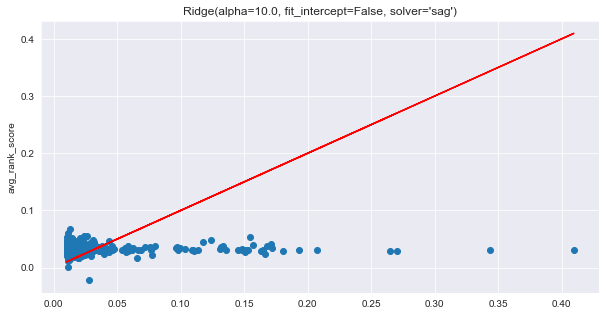

In [795]:
dump(all_models, '../models/linear_regression/linear_regression_all.joblib')
# d = load('../models/linear_regression/linear_regression_all.joblib')

from math import inf
hi = -inf
best_model = None
for am in all_models:
    if am['best_score'] > hi:
        hi = am['best_score']
        best_model = am


y_train = pop_metrics[best_model['y_name']].iloc[y_train_idx]
y_test = pop_metrics[best_model['y_name']].iloc[y_test_idx]

X_train = data_df[best_model['features']].iloc[X_train_idx]
X_test = data_df[best_model['features']].iloc[X_test_idx]

mdl = best_model['base'](**best_model['best_params'])
mdl.fit(X_train, y_train)
y_pred = mdl.predict(X_test)

print(f"Model: {best_model['model']}")
print(f"Params: {best_model['best_params']}")
print(f"CV Score: {best_model['best_score']}")
print(f"Num Features: {len(best_model['features'])}")
print(f"Y-Variable: {best_model['y_name']}")
print(f"Test MSE: {mean_squared_error(y_test, y_pred)}")
print(f"Test R2: {r2_score(y_test, y_pred)}")

fig = plt.figure(figsize=(10,5))
plt.scatter(y_test, y_pred)
plt.plot(y_test,y_test,'r')
plt.title(f"{mdl}")
plt.ylabel(best_model['y_name'])

In [797]:
import os

from keras.models import Sequential
from keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import tensorflow as tf

# from keras_visualizer import visualizer
from ann_visualizer.visualize import ann_viz

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score

import warnings
warnings.filterwarnings('ignore')

In [803]:
spotify_df = pd.read_csv("../data/spofity/songs.csv")
audio_analysis_df = pd.read_csv("../data/audio/audio_features_full.csv")
songs_df = spotify_df.merge(audio_analysis_df, how='inner', on='billboard_name')

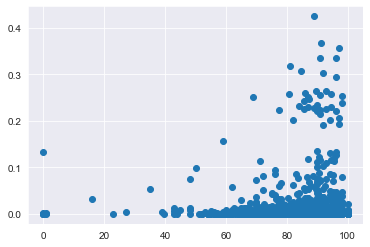

In [812]:
plt.scatter(songs_df['spotify_artist_popularity_mean'], pop_metrics['std_rank_score'])

In [ ]:
pop_metrics